# Import libraries


In [ ]:
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import re

from IPython import display
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (
    Dense,
    Embedding,
    LSTM,
    Conv1D,
    Bidirectional,
    Dropout,
    MaxPooling1D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


# Load dataset


In [ ]:
data_fake = pd.read_csv("/content/drive/MyDrive/FakeNewsDetection/dataset/ISOT/Fake.csv")
data_fake["labels"] = 0
data_fake = data_fake[["text", "labels"]]
data_true = pd.read_csv("/content/drive/MyDrive/FakeNewsDetection/dataset/ISOT/True.csv")
data_true["labels"] = 1
data_true = data_true[["text", "labels"]]
data = pd.concat([data_fake, data_true])
data = data.sample(frac=1)
data


,text,labels
15339,HARARE (Reuters) - Zimbabwe s former vice pres...,1
491,A Category Four hurricane has hit Texas. It s ...,0
21959,Tune in to the Alternate Current Radio Network...,0
15548,America deserves so much better and should get...,0
7632,GENEVA (Reuters) - Syria’s political oppositio...,1
...,...,...
854,"By now, everyone is used to the rank ignorance...",0
7964,Republicans must be shocked. And taxpayers sho...,0
13934,BERLIN (Reuters) - German President Frank-Walt...,1
11265,WASHINGTON (Reuters) - U.S. Vice President Joe...,1


# Extract feature values


In [ ]:
X = data["text"].values
X


array(['HARARE (Reuters) - Zimbabwe s former vice president Emmerson Mnangagwa, who was sacked by President Robert Mugabe this week, has been expelled from the ruling Zanu-PF, a party spokesman said on Wednesday. Mnangagwa, a liberation war veteran and a long-time ally of Mugabe, was until this week seen as a favorite to succeed the 93-year-old leader. But Mnangagwa s relationship with Mugabe s wife, Grace, has become increasingly strained as their two factions within Zanu-PF fight for dominance. Mnangagwa s removal on Monday came two days after Grace publicly called him a  coup plotter . ',
       'A Category Four hurricane has hit Texas. It s set to be the most disastrous hurricane since Katrina hit Louisiana in 2005, yet Donald Trump is using it as an opportunity to deport people.Thousands of people are evacuating the affected areas, trying to beat the storm. Instead of helping ensure that evacuations go smoothly, the Trump administration is doing the exact opposite. They are creati

# Extract label values


In [ ]:
y = data["labels"].values
y


array([1, 0, 0, ..., 1, 1, 0])

# Preprocessing


In [ ]:
lemmatizer = WordNetLemmatizer()

X_clean = []

le = LabelEncoder()
y = le.fit_transform(y)

for i in range(len(X)):
    content = re.sub("[^a-zA-Z]", " ", str(X[i]))
    content = content.lower()
    content = content.split()

    content = [
        lemmatizer.lemmatize(word)
        for word in content
        if not word in stopwords.words("english")
    ]
    content = " ".join(content)
    X_clean.append(content)

X_clean


['harare reuters zimbabwe former vice president emmerson mnangagwa sacked president robert mugabe week expelled ruling zanu pf party spokesman said wednesday mnangagwa liberation war veteran long time ally mugabe week seen favorite succeed year old leader mnangagwa relationship mugabe wife grace become increasingly strained two faction within zanu pf fight dominance mnangagwa removal monday came two day grace publicly called coup plotter',
 'category four hurricane hit texas set disastrous hurricane since katrina hit louisiana yet donald trump using opportunity deport people thousand people evacuating affected area trying beat storm instead helping ensure evacuation go smoothly trump administration exact opposite creating checkpoint forcing people show paper proving documented resident united state federal government closing border patrol checkpoint path hurricane leaving checkpoint open outside path texas tribune report border patrol checkpoint closed unless danger safety traveling pu

In [ ]:
X = []
for xs in X_clean:
    tokenized = xs.split()
    X.append(tokenized)

X


Output hidden; open in https://colab.research.google.com to view.

# TF-IDF


## Define and fit TF-IDF vectorizer


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_ = tfidf_vectorizer.fit_transform(X_clean)

X_


<44898x107018 sparse matrix of type '<class 'numpy.float64'>'
	with 7050143 stored elements in Compressed Sparse Row format>

## Define tokenizer and fit on text data


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_clean)

tokenizer


## Tokenize and pad TF-IDF vectors


In [ ]:
X_ = tokenizer.texts_to_sequences(X_clean)
max_len = 480
X_ = pad_sequences(X_, maxlen=max_len)

X_


array([[    0,     0,     0, ...,    85,  1776, 13891],
       [    0,     0,     0, ...,  2472,   476,    61],
       [    0,     0,     0, ...,  1065,  2477,   949],
       ...,
       [    0,     0,     0, ...,   797,    20,   121],
       [    0,     0,     0, ...,  2974,  5642,  2078],
       [    0,     0,     0, ...,   316,    83, 29379]], dtype=int32)

## Define the embedding dimension


In [ ]:
EMBEDDING_DIM = 100


## Model architecture


In [ ]:
model = Sequential()
model.add(
    Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=EMBEDDING_DIM,
        input_length=max_len,
    )
)
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


## Split data


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2)


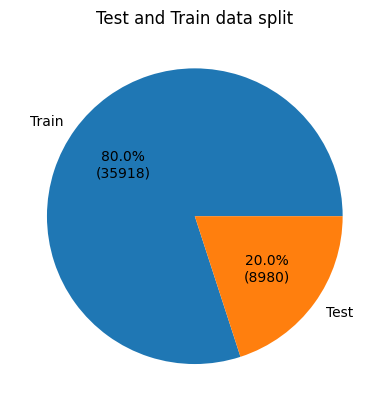

In [ ]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({v:d})".format(pct, v=val)

    return my_format


plt.pie(
    [X_train.shape[0], X_test.shape[0]],
    labels=["Train", "Test"],
    autopct=autopct_format([X_train.shape[0], X_test.shape[0]]),
)
plt.title("Test and Train data split")
plt.show()


## Train the model


In [ ]:
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)


Epoch 1/10
225/225 [==============================] - 822s 4s/step - loss: 0.1256 - accuracy: 0.9469 - val_loss: 0.0234 - val_accuracy: 0.9930
Epoch 2/10
225/225 [==============================] - 811s 4s/step - loss: 0.0138 - accuracy: 0.9965 - val_loss: 0.0347 - val_accuracy: 0.9905
Epoch 3/10
225/225 [==============================] - 824s 4s/step - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.0167 - val_accuracy: 0.9962
Epoch 4/10
225/225 [==============================] - 802s 4s/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0219 - val_accuracy: 0.9936
Epoch 5/10
225/225 [==============================] - 810s 4s/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.0194 - val_accuracy: 0.9944
Epoch 6/10
225/225 [==============================] - 922s 4s/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0147 - val_accuracy: 0.9965
Epoch 7/10
225/225 [==============================] - 868s 4s/step - loss: 7.4489e-04 - accuracy: 0.9999 - val_loss: 0.0365 - val_accuracy: 0.

## Evaluation


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")
accuracy_score_tfidf = accuracy_score(y_test, y_pred)

accuracy_score_tfidf


281/281 [==============================] - 68s 234ms/step


0.9977728285077951

In [ ]:
print(classification_report(y_test, y_pred, digits=5))


              precision    recall  f1-score   support

           0    0.99915   0.99662   0.99788      4729
           1    0.99625   0.99906   0.99765      4251

    accuracy                        0.99777      8980
   macro avg    0.99770   0.99784   0.99777      8980
weighted avg    0.99778   0.99777   0.99777      8980



### Confusion Matrix


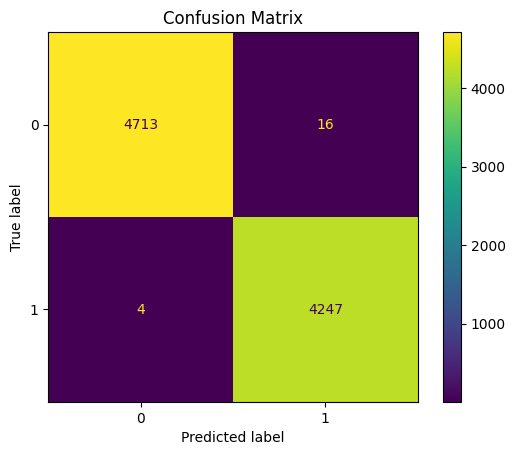

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix")
plt.show()


## Save the model for using it in the website


In [ ]:
model.save("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/tf-idf/model.h5")
pickle.dump(
    tokenizer,
    open(
        "/content/drive/MyDrive/FakeNewsDetection/model/ISOT/tf-idf/tokenizer", "wb"
    ),
)

# Save splitted dataset
arr = np.array(X_train)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/tf-idf/X_train.txt", arr)
y_test_np = np.array(X_test)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/tf-idf/X_test.txt", arr)
y_test_np = np.array(y_train)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/tf-idf/y_train.txt", arr)
y_test_np = np.array(y_test)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/tf-idf/y_test.txt", arr)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Word2Vec


# Train word embeddings


In [ ]:
X_ = X


## Define the embedding dimension


In [ ]:
EMBEDDING_DIM = 100


## Define Word2Vec model


In [ ]:
w2v_model = gensim.models.Word2Vec(
    sentences=X_, vector_size=EMBEDDING_DIM, window=5, min_count=1
)

w2v_model


## Define tokenizer and fit on text data


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_)

tokenizer


## Tokenize and pad vectors


In [ ]:
X_ = tokenizer.texts_to_sequences(X_)
max_len = 480
X_ = pad_sequences(X_, maxlen=max_len)

X_


array([[    0,     0,     0, ...,    85,  1776, 13891],
       [    0,     0,     0, ...,  2472,   476,    61],
       [    0,     0,     0, ...,  1065,  2477,   949],
       ...,
       [    0,     0,     0, ...,   797,    20,   121],
       [    0,     0,     0, ...,  2974,  5642,  2078],
       [    0,     0,     0, ...,   316,    83, 29379]], dtype=int32)

In [ ]:
voc_size = len(tokenizer.word_index) + 1

wm = np.zeros((voc_size, EMBEDDING_DIM))

for w, i in tokenizer.word_index.items():
    wm[i] = w2v_model.wv[w]

wm


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.85563225e-02, -1.06198561e+00,  1.39097011e+00, ...,
         2.18417311e+00,  2.04563618e+00,  1.55743909e+00],
       [-8.47493529e-01, -1.12853146e+00, -7.79694498e-01, ...,
        -2.05940533e+00, -9.12495613e-01,  2.65746206e-01],
       ...,
       [ 7.02614756e-03,  2.22972408e-02,  2.07743235e-03, ...,
        -1.71561744e-02,  3.69492546e-02, -2.30054162e-03],
       [ 4.41828743e-02, -2.68877279e-02,  3.00099943e-02, ...,
        -1.57781795e-03,  5.27221337e-03, -4.00569662e-03],
       [-1.85888652e-02,  2.18488593e-02,  1.28845284e-02, ...,
        -1.16851004e-02,  5.88023895e-03,  2.73906533e-03]])

## Model architecture


In [ ]:
model = Sequential()
model.add(
    Embedding(
        voc_size,
        output_dim=EMBEDDING_DIM,
        weights=[wm],
        input_length=max_len,
        trainable=False,
    )
)
model.add(Conv1D(128, 3, activation="relu"))
model.add(MaxPooling1D())
model.add(Dense(256))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])


## Split data


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2)


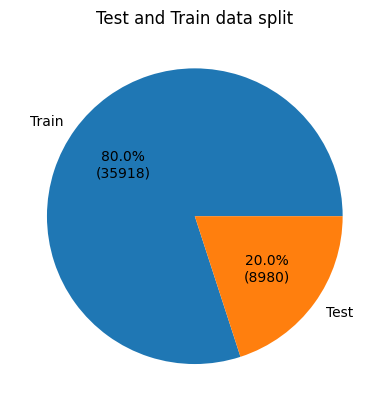

In [ ]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({v:d})".format(pct, v=val)

    return my_format


plt.pie(
    [X_train.shape[0], X_test.shape[0]],
    labels=["Train", "Test"],
    autopct=autopct_format([X_train.shape[0], X_test.shape[0]]),
)
plt.title("Test and Train data split")
plt.show()


## Train the model


In [ ]:
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)


Epoch 1/10
225/225 [==============================] - 823s 4s/step - loss: 0.0934 - acc: 0.9653 - val_loss: 0.0118 - val_acc: 0.9967
Epoch 2/10
225/225 [==============================] - 793s 4s/step - loss: 0.0127 - acc: 0.9961 - val_loss: 0.0252 - val_acc: 0.9929
Epoch 3/10
225/225 [==============================] - 817s 4s/step - loss: 0.0099 - acc: 0.9971 - val_loss: 0.0062 - val_acc: 0.9983
Epoch 4/10
225/225 [==============================] - 838s 4s/step - loss: 0.0075 - acc: 0.9974 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 5/10
225/225 [==============================] - 799s 4s/step - loss: 0.0050 - acc: 0.9987 - val_loss: 0.0083 - val_acc: 0.9976
Epoch 6/10
225/225 [==============================] - 792s 4s/step - loss: 0.0038 - acc: 0.9986 - val_loss: 0.0072 - val_acc: 0.9983
Epoch 7/10
225/225 [==============================] - 792s 4s/step - loss: 0.0037 - acc: 0.9989 - val_loss: 0.0056 - val_acc: 0.9986
Epoch 8/10
225/225 [==============================] - 791s 4s/step - 

## Evaluation


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")
accuracy_score_word2vec = accuracy_score(y_test, y_pred)

accuracy_score_word2vec


281/281 [==============================] - 89s 303ms/step


0.9975501113585746

In [ ]:
print(classification_report(y_test, y_pred, digits=5))


              precision    recall  f1-score   support

           0    0.99831   0.99704   0.99767      4728
           1    0.99671   0.99812   0.99741      4252

    accuracy                        0.99755      8980
   macro avg    0.99751   0.99758   0.99754      8980
weighted avg    0.99755   0.99755   0.99755      8980



### Confusion Matrix


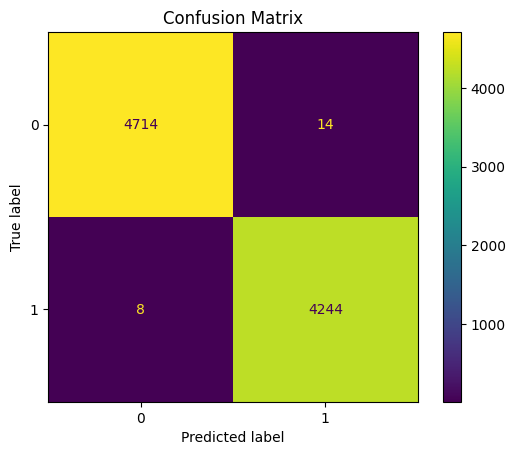

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix")
plt.show()


## Save the model for using it in the website


In [ ]:
model.save("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/word2vec/model.h5")
pickle.dump(
    tokenizer,
    open(
        "/content/drive/MyDrive/FakeNewsDetection/model/ISOT/word2vec/tokenizer", "wb"
    ),
)

# Save splitted dataset
arr = np.array(X_train)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/word2vec/X_train.txt", arr)
y_test_np = np.array(X_test)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/word2vec/X_test.txt", arr)
y_test_np = np.array(y_train)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/word2vec/y_train.txt", arr)
y_test_np = np.array(y_test)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/word2vec/y_test.txt", arr)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Glove


In [ ]:
X_ = X


## Define tokenizer and fit on text data


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_)

tokenizer


## Tokenize


In [ ]:
X_ = tokenizer.texts_to_sequences(X_)

X_


Output hidden; open in https://colab.research.google.com to view.

## Get pre-trained word embeddings


In [ ]:
word_dict = {}

embeddings_file = open("/content/drive/MyDrive/FakeNewsDetection/glove.6B.100d.txt")
for line in embeddings_file:
    values = line.split(" ")
    word = values[0]
    embeddings = values[1:]
    word_dict[word] = embeddings

word_dict


{'the': ['-0.038194',
  '-0.24487',
  '0.72812',
  '-0.39961',
  '0.083172',
  '0.043953',
  '-0.39141',
  '0.3344',
  '-0.57545',
  '0.087459',
  '0.28787',
  '-0.06731',
  '0.30906',
  '-0.26384',
  '-0.13231',
  '-0.20757',
  '0.33395',
  '-0.33848',
  '-0.31743',
  '-0.48336',
  '0.1464',
  '-0.37304',
  '0.34577',
  '0.052041',
  '0.44946',
  '-0.46971',
  '0.02628',
  '-0.54155',
  '-0.15518',
  '-0.14107',
  '-0.039722',
  '0.28277',
  '0.14393',
  '0.23464',
  '-0.31021',
  '0.086173',
  '0.20397',
  '0.52624',
  '0.17164',
  '-0.082378',
  '-0.71787',
  '-0.41531',
  '0.20335',
  '-0.12763',
  '0.41367',
  '0.55187',
  '0.57908',
  '-0.33477',
  '-0.36559',
  '-0.54857',
  '-0.062892',
  '0.26584',
  '0.30205',
  '0.99775',
  '-0.80481',
  '-3.0243',
  '0.01254',
  '-0.36942',
  '2.2167',
  '0.72201',
  '-0.24978',
  '0.92136',
  '0.034514',
  '0.46745',
  '1.1079',
  '-0.19358',
  '-0.074575',
  '0.23353',
  '-0.052062',
  '-0.22044',
  '0.057162',
  '-0.15806',
  '-0.30798',

## Pad vectors


In [ ]:
max_len = 480

X_ = pad_sequences(X_, maxlen=max_len)

X_


array([[    0,     0,     0, ...,    85,  1776, 13891],
       [    0,     0,     0, ...,  2472,   476,    61],
       [    0,     0,     0, ...,  1065,  2477,   949],
       ...,
       [    0,     0,     0, ...,   797,    20,   121],
       [    0,     0,     0, ...,  2974,  5642,  2078],
       [    0,     0,     0, ...,   316,    83, 29379]], dtype=int32)

## Define the embedding dimension


In [ ]:
EMBEDDING_DIM = 100


In [ ]:
voc_size = len(word_dict.keys()) + 1

wm = np.zeros((voc_size, EMBEDDING_DIM))

for w, i in tokenizer.word_index.items():
    if w in word_dict:
        wm[i] = word_dict[w]

wm


array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.15731 , -0.75503 ,  0.36845 , ..., -0.54137 ,  0.67817 ,
        -0.17251 ],
       [-0.13128 , -0.452   ,  0.043399, ..., -0.30526 , -0.045495,
         0.56509 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

## Model architecture


In [ ]:
model = Sequential()
model.add(
    Embedding(
        voc_size,
        output_dim=EMBEDDING_DIM,
        weights=[wm],
        input_length=max_len,
        trainable=False,
    )
)
model.add(Conv1D(128, 3, activation="relu"))
model.add(MaxPooling1D())
model.add(Dense(256))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])


## Split data


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2)


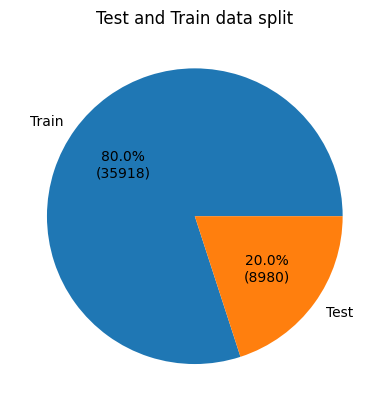

In [ ]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({v:d})".format(pct, v=val)

    return my_format


plt.pie(
    [X_train.shape[0], X_test.shape[0]],
    labels=["Train", "Test"],
    autopct=autopct_format([X_train.shape[0], X_test.shape[0]]),
)
plt.title("Test and Train data split")
plt.show()


## Train the model


In [7]:
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)


NameError: name 'model' is not defined

## Evaluation


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")
accuracy_score_glove = accuracy_score(y_test, y_pred)

accuracy_score_glove


In [ ]:
print(classification_report(y_test, y_pred, digits=5))


### Confusion Matrix


In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix")
plt.show()


# Save the model for using it in the website


In [ ]:
model.save("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/glove/model.h5")
pickle.dump(
    tokenizer,
    open("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/glove/tokenizer", "wb"),
)

# Save splitted dataset
arr = np.array(X_train)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/glove/X_train.txt", arr)
y_test_np = np.array(X_test)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/glove/X_test.txt", arr)
y_test_np = np.array(y_train)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/glove/y_train.txt", arr)
y_test_np = np.array(y_test)
np.savetxt("/content/drive/MyDrive/FakeNewsDetection/model/ISOT/glove/y_test.txt", arr)


# Result


In [ ]:
x = np.array(["Tf-IDF", "Word2Vec", "Glove"])
y = np.array([accuracy_score_tfidf * 100, accuracy_score_word2vec * 100, accuracy_score_glove * 100])

fig, ax = plt.subplots()

plot = ax.bar(x, y)
ax.set(ylim=[99, 100])
plt.bar_label(plot)
plt.title("Accuracy score of each model")
plt.show()
